# DATA2001 Assignment Group F10C-Lab06 - 5

## Load packages 

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely import wkt
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

ModuleNotFoundError: No module named 'geopandas'

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely import wkt
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

ModuleNotFoundError: No module named 'geopandas'

## Load post-gre

In [5]:
# Load post-gre
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json
import os

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

db, conn = pgconnect(credentials)

Connected successfully.


In [62]:
#define some global vars
save_data = True #if true then in the viz and final table section data will be saved to disk

## Define SRID

In [6]:
srid = 4326 #SRID to represent the WGS84 world geodetic coordinate system 


## Load data 

In [7]:
SA2_data = gpd.read_file("SA2/SA2_2016_AUST.shp")
business = pd.read_csv('BusinessStats.csv')
neighbourhoods = pd.read_csv('Neighbourhoods.csv')
break_enter = gpd.read_file("break_and_enter/BreakEnterDwelling_JanToDec2021.shp")

In [8]:
catchments_future = gpd.read_file("school_catchments/catchments_future.shp")
catchments_secondary = gpd.read_file("school_catchments/catchments_secondary.shp")
catchments_primary = gpd.read_file("school_catchments/catchments_primary.shp")

In [9]:
break_enter = gpd.read_file("break_and_enter/BreakEnterDwelling_JanToDec2021.shp")

In [10]:
mobility_parking = gpd.read_file('Mobility_parking.geojson')

In [11]:
lifts = gpd.read_file('Lifts.geojson')

## Clean and Refine data 

For shape data, we need to convert them to the WGS84 coordinate system and convert polygons to multipolygons

In [12]:
# Defining functions to do the above
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

def preprocess_geometry(shape_data):
    if(hasattr(shape_data['geometry'][0], 'geom_type')):
        shape_data['geometry'] = shape_data['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
        return shape_data
    else:
        assert(isinstance(shape_data['geometry'][0], WKTElement))
        print("Geometry already processed")
        return shape_data

### SA 2 data
We are only interested in SA2 data coming from NSW. The new dataframe will only contain the attributes "SA2_MAIN16", "SA_NAME16", "geometry". We will convert the polygons in the SA2_NSW dataframe to multipolygons (not sure why yet). Then convert to WGS84 standards. 

In [13]:
SA2_NSW = SA2_data[['SA2_MAIN16','SA2_NAME16','geometry']].copy()
SA2_NSW = SA2_NSW[SA2_data['GCC_NAME16']== 'Greater Sydney']# filter for NSW SA2 data only 
SA2_NSW = SA2_NSW[SA2_NSW['geometry'].notnull()] #remove rows where we have no spatial data

#rename the columns 
SA2_NSW.rename(columns = {'SA2_MAIN16':'area_id','SA2_NAME16':'area_name', 'geometry':'geom'}, inplace = True)

SA2_NSW['geometry'] = SA2_NSW['geom'].apply(lambda x: create_wkt_element(geom=x,srid=srid)) 
SA2_NSW = SA2_NSW.drop(columns="geom")  # deleting the old geometry column that contained polygons 
SA2_NSW

,area_id,area_name,geometry
27,102011028,Avoca Beach - Copacabana,MULTIPOLYGON (((151.4137275700001 -33.46559324...
28,102011029,Box Head - MacMasters Beach,MULTIPOLYGON (((151.3539836770001 -33.49854010...
29,102011030,Calga - Kulnura,MULTIPOLYGON (((151.204595054 -33.532982995999...
30,102011031,Erina - Green Point,MULTIPOLYGON (((151.3679483220001 -33.43822416...
31,102011032,Gosford - Springfield,MULTIPOLYGON (((151.310060818 -33.426989095999...
...,...,...,...
571,128021537,Royal National Park,MULTIPOLYGON (((151.071650994 -34.057945007999...
572,128021538,Sutherland - Kirrawee,MULTIPOLYGON (((151.05049439 -34.0200584319999...
573,128021607,Engadine,MULTIPOLYGON (((150.9956780320001 -34.05362100...
574,128021608,Loftus - Yarrawarrah,MULTIPOLYGON (((151.0395427830001 -34.04175791...


### City of sydney data 

In [14]:
sydney_city = SA2_data[['SA2_MAIN16','SA4_NAME16','geometry']].copy()
sydney_city = sydney_city[sydney_city['SA4_NAME16']== 'Sydney - City and Inner South']# filter for NSW SA2 data only 
sydney_city = sydney_city[sydney_city['geometry'].notnull()] #remove rows where we have no spatial data

#rename the columns 
sydney_city.rename(columns = {'SA2_MAIN16':'area_id','SA4_NAME16':'area_name', 'geometry':'geom'}, inplace = True)

sydney_city['geometry'] = sydney_city['geom'].apply(lambda x: create_wkt_element(geom=x,srid=srid)) 
sydney_city = sydney_city.drop(columns="geom")  # deleting the old geometry column that contained polygons 
sydney_city

,area_id,area_name,geometry
330,117011320,Sydney - City and Inner South,MULTIPOLYGON (((151.2080616410001 -33.95405921...
331,117011321,Sydney - City and Inner South,MULTIPOLYGON (((151.1887901160001 -33.94453197...
332,117011322,Sydney - City and Inner South,MULTIPOLYGON (((151.1824130910001 -33.92628848...
333,117011323,Sydney - City and Inner South,MULTIPOLYGON (((151.2214122090001 -33.92630607...
334,117011324,Sydney - City and Inner South,MULTIPOLYGON (((151.2209020130001 -33.96896500...
335,117011325,Sydney - City and Inner South,MULTIPOLYGON (((151.1625973500001 -33.93277482...
336,117021326,Sydney - City and Inner South,MULTIPOLYGON (((151.145826732 -33.906642979999...
337,117021327,Sydney - City and Inner South,MULTIPOLYGON (((151.1676989920001 -33.88795920...
338,117021328,Sydney - City and Inner South,MULTIPOLYGON (((151.1646696020001 -33.91576244...
339,117031329,Sydney - City and Inner South,MULTIPOLYGON (((151.2122688500001 -33.87632702...


### Bussiness

In [15]:
business = business.drop(columns = ['area_name','agriculture_forestry_and_fishing','transport_postal_and_warehousing'])

### Neighbourhood dataset 

In [16]:
# Creating Neighbourhood Dataset 
young_population = neighbourhoods["0-4"] + neighbourhoods["5-9"] + neighbourhoods["10-14"] + neighbourhoods["15-19"]
neighbourhoods["young_population"] = young_population
new_neighbourhoods = neighbourhoods.drop(["area_name", "number_of_dwellings", "median_annual_household_income", 
                                         "number_of_businesses","avg_monthly_rent", "0-4", "5-9", "10-14", "15-19"], axis=1)
new_neighbourhoods = new_neighbourhoods.dropna()
new_neighbourhoods = new_neighbourhoods[pd.to_numeric(new_neighbourhoods['population'], errors='coerce').notnull()]

#re-name
new_neighbourhoods.rename(columns = {'Unnamed: 0':'neighbourhood_id'}, inplace = True)

### Housing dataset 

In [17]:
# Creating Housing Dataset
housing = neighbourhoods.drop(["Unnamed: 0", "area_name", "land_area", "population",
                               "number_of_businesses", "0-4", "5-9", "10-14", "15-19", "young_population"], axis=1)
housing = housing[pd.to_numeric(housing['number_of_dwellings'], errors='coerce').notnull()]
housing = housing.dropna()



### School datasets 

In [18]:
# convert to WGS84 coordinate system
catchments_future = preprocess_geometry(catchments_future)
catchments_secondary = preprocess_geometry(catchments_secondary)
catchments_primary = preprocess_geometry(catchments_primary)
print(catchments_future.head())

  USE_ID CATCH_TYPE          USE_DESC  ADD_DATE  KINDERGART  YEAR1  YEAR2  \
0   2133    PRIMARY        Harbord PS  20200720        2023   2023   2023   
1   4450    PRIMARY        Berinba PS  20220110        2023   2023   2023   
2   4683    PRIMARY  Murrumbateman PS  20220110        2023   2023   2023   
3   4021    PRIMARY     Manly Vale PS  20200805        2023   2023   2023   
4   8161  HIGH_BOYS      Randwick BHS  20200220           0      0      0   

   YEAR3  YEAR4  YEAR5  YEAR6  YEAR7  YEAR8  YEAR9  YEAR10  YEAR11  YEAR12  \
0   2023   2023   2023   2023      0      0      0       0       0       0   
1   2023   2023   2023   2023      0      0      0       0       0       0   
2   2023   2023   2023   2023      0      0      0       0       0       0   
3   2023   2023   2023   2023      0      0      0       0       0       0   
4      0      0      0      0   2023   2023   2023    2023    2023    2023   

                                            geometry  
0  MULTIPOLYG

In [19]:
#replace all cols with their lower case version
def rename_lower_case(shape_data):
    lower_case_names = {}
    for i in shape_data.columns:
        lower_case_names[i] = i.lower()

    # print(lower_case_names)
    shape_data.rename(columns=lower_case_names, inplace=True)
    return shape_data.copy()

#for now also get rid of the priortiy column and add_date column
def safe_column_remove(column_str, shape_data):
    if column_str in shape_data:
        print("Removing {} column".format(column_str))
        shape_data = shape_data.drop(columns=column_str)
    return shape_data


catchments_future = rename_lower_case(catchments_future)
catchments_secondary = rename_lower_case(catchments_secondary)
catchments_primary = rename_lower_case(catchments_primary)


catchments_future = safe_column_remove("priority",catchments_future)
catchments_secondary = safe_column_remove("priority",catchments_secondary)
catchments_primary = safe_column_remove("priority", catchments_primary)
catchments_future = safe_column_remove("add_date",catchments_future)
catchments_secondary = safe_column_remove("add_date",catchments_secondary)
catchments_primary = safe_column_remove("add_date", catchments_primary)


Removing priority column
Removing priority column
Removing add_date column
Removing add_date column
Removing add_date column


In [20]:
#preprocess on future only as we convert the data to Y/N for kindergarten -> year 12
year_keys = ["kindergart"]
for x in range(12):
    year_keys.append("year" + str(x + 1))
print(year_keys)
    
def year_to_bool(x):
    if x > 0:
        return 'Y'
    else:
        return 'N'

for year in year_keys:
    catchments_future[year] = catchments_future[year].apply(year_to_bool)




['kindergart', 'year1', 'year2', 'year3', 'year4', 'year5', 'year6', 'year7', 'year8', 'year9', 'year10', 'year11', 'year12']


### Break and Enter 

In [21]:
break_in_geometry = preprocess_geometry(break_enter)
break_in_geometry = rename_lower_case(break_enter)
#drop some unneeded tables
break_in_geometry = break_in_geometry.drop(columns = 'orig_fid')
break_in_geometry = break_in_geometry.drop(columns = 'contour')


In [22]:
break_in_geometry

,objectid,density,shape_leng,shape_area,geometry
0,1,Low Density,0.012138,0.000006,MULTIPOLYGON (((149.9107801470001 -37.06636313...
1,2,Low Density,0.019106,0.000015,MULTIPOLYGON (((149.9060088220001 -37.05836717...
2,3,Low Density,0.006068,0.000002,MULTIPOLYGON (((148.9424993900001 -37.04208530...
3,4,Low Density,0.011006,0.000006,MULTIPOLYGON (((149.1958326340001 -36.91833255...
4,5,Low Density,0.008073,0.000003,MULTIPOLYGON (((149.8483600650001 -36.68458912...
...,...,...,...,...,...
2589,2590,High Density,0.015358,0.000011,MULTIPOLYGON (((153.2796105350001 -28.55387845...
2590,2591,High Density,0.028327,0.000029,MULTIPOLYGON (((150.3593920080001 -28.60530123...
2591,2592,High Density,0.006654,0.000002,MULTIPOLYGON (((153.568248161 -28.383068159999...
2592,2593,High Density,0.047098,0.000044,MULTIPOLYGON (((153.5391676050001 -28.18857974...


### Mobility parking 

In [23]:
# Convert to WKT data 
mobility_parking['geometry']=mobility_parking['geometry'].apply(lambda x: WKTElement(x.wkt, srid=srid))

mobility_parking_og = mobility_parking.copy()
mobility_parking = mobility_parking[['OBJECTID','NumberParkingSpaces','geometry']].copy()

#rename the columns 
mobility_parking.rename(columns = {'OBJECTID':'parking_id','NumberParkingSpaces':'number_parking_spaces'}, inplace = True)
mobility_parking

,parking_id,number_parking_spaces,geometry
0,1,2,POINT Z (151.207737645743 -33.8565395152761 0)
1,2,1,POINT Z (151.188402178523 -33.9026818665228 0)
2,3,1,POINT Z (151.181060862061 -33.9046212044313 0)
3,4,2,POINT Z (151.205381498052 -33.8825770410705 0)
4,5,1,POINT Z (151.205208290857 -33.8944134463663 0)
...,...,...,...
197,201,1,POINT Z (151.191155655124 -33.8776400806325 0)
198,202,1,POINT Z (151.191632839301 -33.8784073032424 0)
199,203,1,POINT Z (151.208690816832 -33.8659142172315 0)
200,204,1,POINT Z (151.209054192822 -33.8632857888013 0)


### Lifts 

In [24]:
lifts['geometry']=lifts['geometry'].apply(lambda x: WKTElement(x.wkt, srid=srid))
lifts = lifts[['OBJECTID','geometry']]
#rename the columns 
lifts.rename(columns = {'OBJECTID':'lift_id'}, inplace = True)

## Create SQL tables 

### Non-spatial data + SA2

In [26]:
#area_location 
conn.execute("""
DROP TABLE IF EXISTS area_location CASCADE;
CREATE TABLE area_location (
    area_id VARCHAR(10) PRIMARY KEY,
    area_name VARCHAR(100),
    geometry GEOMETRY(MULTIPOLYGON,4326));
""")

# bussiness 
conn.execute("""
DROP TABLE IF EXISTS business; 
CREATE TABLE business( 
    area_id VARCHAR(10) PRIMARY KEY,
    number_of_businesses INTEGER,
    accommodation_and_food_services INTEGER, 
    retail_trade INTEGER,
    health_care_and_social_assistance INTEGER, 
    public_administration_and_safety INTEGER);
""")

# neighbourhoods
conn.execute("""
DROP TABLE IF EXISTS neighbourhoods; 
CREATE TABLE neighbourhoods( 
    neighbourhood_id VARCHAR(10) PRIMARY KEY,
    area_id VARCHAR(10) REFERENCES area_location(area_id),
    land_area FLOAT, 
    population INT,
    young_population INT);
""")

# housing 
conn.execute("""
DROP TABLE IF EXISTS Housing; 
CREATE TABLE Housing( 
    area_id VARCHAR(10) PRIMARY KEY,
    number_of_dwellings INTEGER,
    median_annual_household_income INTEGER,
    avg_monthly_rent INTEGER);
""")


### City of Sydney 

In [28]:
#area_location 
conn.execute("""
DROP TABLE IF EXISTS city_sydney CASCADE;
CREATE TABLE city_sydney (
    area_id VARCHAR(10) PRIMARY KEY,
    area_name VARCHAR(100),
    geometry GEOMETRY(MULTIPOLYGON,4326));
""")

### School catchment 

In [29]:
def create_school_catchment_table(table_name, conn):
    print("Making school table: {}".format(table_name))
    result = conn.execute("""
    DROP TABLE IF EXISTS {} CASCADE;
    CREATE TABLE {} (
        use_id INT,
        catch_type VARCHAR(100), 
        use_desc VARCHAR(100), 
        kindergart CHAR,
        year1 CHAR,
        year2 CHAR,
        year3 CHAR,
        year4 CHAR,
        year5 CHAR,
        year6 CHAR,
        year7 CHAR,
        year8 CHAR,
        year9 CHAR,
        year10 CHAR,
        year11 CHAR,
        year12 CHAR,
        geometry GEOMETRY(MULTIPOLYGON,4326)
    );""".format(table_name, table_name)
    )

create_school_catchment_table("catchments_future", conn)
create_school_catchment_table("catchments_primary", conn)
create_school_catchment_table("catchments_secondary", conn)


Making school table: catchments_future
Making school table: catchments_primary
Making school table: catchments_secondary


### Break and Enter

In [30]:
def create_break_in_table(table_name, conn):
    print("Making break in table: {}".format(table_name))
    result = conn.execute("""
    DROP TABLE IF EXISTS {} CASCADE;
    CREATE TABLE {} (
        objectid INT,
        density VARCHAR(100), 
        shape_leng FLOAT,
        shape_area FLOAT,
        geometry GEOMETRY(MULTIPOLYGON,4326)
    );""".format(table_name, table_name)
    )

create_break_in_table("break_ins", conn)


Making break in table: break_ins


### Mobility parking

In [33]:
conn.execute("""
DROP TABLE IF EXISTS mobility_parking CASCADE;
CREATE TABLE mobility_parking (
    parking_id VARCHAR(10) PRIMARY KEY,
    number_parking_spaces INTEGER,
    geometry GEOMETRY(POINTZ,4326));
""")

### Lifts 

In [34]:
conn.execute("""
DROP TABLE IF EXISTS lifts CASCADE;
CREATE TABLE lifts (
    lift_id VARCHAR(10) PRIMARY KEY,
    geometry GEOMETRY(POINT,4326));
""")

## Populate tables 

Bussiness, SA2, neighbourhood, housing:

In [35]:
business.to_sql('business', conn, if_exists = 'append', index = False)
SA2_NSW.to_sql("area_location", conn, if_exists = 'append',index=False, dtype={'geometry': Geometry('MULTIPOLYGON', srid)})
new_neighbourhoods.to_sql('neighbourhoods', conn, if_exists = 'append', index = False)
housing.to_sql('housing', conn, if_exists = 'append', index = False)


City of Sydney 

In [36]:
sydney_city.to_sql("city_sydney", conn, if_exists = 'append',index=False, dtype={'geometry': Geometry('MULTIPOLYGON', srid)})

School catchment

In [37]:
catchments_future.to_sql('catchments_future', conn, if_exists = 'append', index = False, dtype={'geometry': Geometry('MULTIPOLYGON', srid)})
catchments_primary.to_sql('catchments_primary', conn, if_exists = 'append', index = False, dtype={'geometry': Geometry('MULTIPOLYGON', srid)})
catchments_secondary.to_sql('catchments_secondary', conn, if_exists = 'append', index = False, dtype={'geometry': Geometry('MULTIPOLYGON', srid)})



Break ins

In [38]:
break_in_geometry.to_sql('break_ins', conn, if_exists = 'append', index = False, dtype={'geometry': Geometry('MULTIPOLYGON', srid)})

Mobility parking 

In [39]:
mobility_parking.to_sql('mobility_parking', conn, if_exists = 'append', index = False,dtype={'geometry': Geometry('POINT', srid)})

Lifts

In [40]:
lifts.to_sql('lifts', conn, if_exists = 'append', index = False, dtype={'geometry': Geometry('POINT', srid)})

## Create Indicies for quicker querying 

Make one for the most used joins

In [41]:
# Make one on the area_loaction attribute 'area_id' 
conn.execute("""
DROP INDEX IF EXISTS area_loc_id_idx;
CREATE INDEX area_loc_id_idx ON area_location(area_id);
""")

In [42]:
# Make one on the area_loaction attribute 'area_id' 
conn.execute("""
DROP INDEX IF EXISTS area_id_neigh_idx;
CREATE INDEX area_id_neigh_idx ON neighbourhoods(area_id);
""")

Make on for every geometry join 

In [43]:
# Make one on the area_loaction attribute 'geometry' 
conn.execute("""
DROP INDEX IF EXISTS area_geom;
CREATE INDEX area_geom ON area_location USING GIST (geometry);
""")

In [44]:
# Make one on the catchments_primary attribute 'geometry' 
conn.execute("""
DROP INDEX IF EXISTS school_prim_geom;
CREATE INDEX school_prim_geom ON catchments_primary USING GIST (geometry);
""")

In [45]:
# Make one on the catchments_secondary attribute 'geometry' 
conn.execute("""
DROP INDEX IF EXISTS school_sec_geom;
CREATE INDEX school_sec_geom ON catchments_secondary USING GIST (geometry);
""")

In [46]:
# Make one on the catchments_future attribute 'geometry' 
conn.execute("""
DROP INDEX IF EXISTS school_fut_geom;
CREATE INDEX school_fut_geom ON catchments_future USING GIST (geometry);
""")

In [47]:
# Make one on the lifts attribute 'geometry' 

conn.execute("""
DROP INDEX IF EXISTS lift_geom;
CREATE INDEX lift_geom ON lifts USING GIST (geometry);
""")

In [48]:
# Make one on the mobility_parking attribute 'geometry' 

conn.execute("""
DROP INDEX IF EXISTS park_geom;
CREATE INDEX park_geom ON mobility_parking USING GIST (geometry);
""")

In [49]:
# Make one on the break_ins attribute 'geometry' 

conn.execute("""
DROP INDEX IF EXISTS break_geom;
CREATE INDEX break_geom ON break_ins USING GIST (geometry);
""")

In [50]:
# Make one on the city_sydney attribute 'geometry' 

conn.execute("""
DROP INDEX IF EXISTS city_sydney_indx_geo;
CREATE INDEX city_sydney_indx_geo ON city_sydney USING GIST (geometry);
""")

## Create Tables

Schools per 1000

In [51]:
# # try and get unique number of catchments per area

sql = """
DROP TABLE IF EXISTS school;
DROP VIEW IF EXISTS school_primary;
DROP VIEW IF EXISTS school_secondary;
DROP VIEW IF EXISTS school_future;
CREATE VIEW school_primary as
 SELECT A.area_id, A.area_name, A.geometry, COUNT(B.use_desc) as count_primary
 FROM area_location A
 LEFT JOIN catchments_primary B ON ST_Intersects(B.geometry, A.geometry)
 LEFT JOIN neighbourhoods ON neighbourhoods.area_id=A.area_id
 GROUP BY A.area_id, A.area_name, A.geometry,  neighbourhoods.young_population;

CREATE VIEW school_secondary as
 SELECT A.area_id, A.area_name, A.geometry, COUNT(B.use_desc) as count_secondary,
 neighbourhoods.young_population as young_population
 FROM area_location A
 LEFT JOIN catchments_secondary B ON ST_Intersects(B.geometry, A.geometry)
 LEFT JOIN neighbourhoods ON neighbourhoods.area_id=A.area_id
 GROUP BY A.area_id, A.area_name, A.geometry,  neighbourhoods.young_population;

CREATE VIEW school_future as
 SELECT A.area_id, A.area_name, A.geometry, COUNT(B.use_desc) as count_future
 FROM area_location A
 LEFT JOIN catchments_future B ON ST_Intersects(B.geometry, A.geometry)
 LEFT JOIN neighbourhoods ON neighbourhoods.area_id=A.area_id
 GROUP BY A.area_id, A.area_name, A.geometry,  neighbourhoods.young_population;

CREATE TABLE school AS
  SELECT A.*, B.count_primary, C.count_future, 
    (A.count_secondary + B.count_primary + C.count_future) AS total_schools,
    ( A.young_population/1000.0/(A.count_secondary + B.count_primary + C.count_future)) 
    AS schools_per_1000

  FROM school_secondary A 
  LEFT JOIN school_primary B ON A.area_id = B.area_id
  LEFT JOIN school_future C ON A.area_id = C.area_id
  WHERE A.* IS NOT NULL AND B.count_primary is NOT NULL AND C.count_future IS NOT NULL;

SELECT * FROM school;
"""
df_school = pd.read_sql(sql, conn)
# df_school = df_school.dropna()
df_school


,area_id,area_name,geometry,count_secondary,young_population,count_primary,count_future,total_schools,schools_per_1000
0,102011028,Avoca Beach - Copacabana,0106000020E6100000010000000103000000010000005E...,2,2214,4,0,6,0.369000
1,102011029,Box Head - MacMasters Beach,0106000020E61000000100000001030000000100000000...,3,2635,5,0,8,0.329375
2,102011030,Calga - Kulnura,0106000020E61000000200000001030000000100000085...,9,1098,18,0,27,0.040667
3,102011031,Erina - Green Point,0106000020E61000000100000001030000000100000041...,7,3227,10,0,17,0.189824
4,102011032,Gosford - Springfield,0106000020E6100000010000000103000000010000007F...,4,4219,10,0,14,0.301357
...,...,...,...,...,...,...,...,...,...
306,128021537,Royal National Park,0106000020E61000000100000001030000000100000047...,6,8,11,2,19,0.000421
307,128021538,Sutherland - Kirrawee,0106000020E61000000100000001030000000100000089...,4,4894,11,2,17,0.287882
308,128021607,Engadine,0106000020E6100000010000000103000000010000008E...,4,5176,7,2,13,0.398154
309,128021608,Loftus - Yarrawarrah,0106000020E610000001000000010300000001000000A1...,2,2054,4,2,8,0.256750


non-geo

In [52]:
sql = """
DROP TABLE  IF EXISTS non_geo;
CREATE TABLE  non_geo AS 
SELECT A.area_id, A.area_name, A.geometry, sum(business.accommodation_and_food_services) as t, 
AVG(housing.avg_monthly_rent) as Average_Monthly_Rent, 
AVG(housing.median_annual_household_income) as Average_Median_Annual_Household_Income,
sum(business.retail_trade) as r, sum(business.health_care_and_social_assistance) as h,
    sum(neighbourhoods.population)as total_population, 
    case when sum(neighbourhoods.population)/1000.0 = 0 THEN 0 
        else sum(business.accommodation_and_food_services)/(sum(neighbourhoods.population)/1000.0)
        end as accommodation_and_food_services1000,
    case when sum(neighbourhoods.population)/1000.0 = 0 THEN 0 
        else sum(business.retail_trade)/(sum(neighbourhoods.population)/1000.0)
        end as retail_trade1000, 
    case when sum(neighbourhoods.population)/1000.0 = 0 THEN 0 
        else sum(business.health_care_and_social_assistance)/(sum(neighbourhoods.population)/1000.0)
        end as health_care_and_social_assistance1000 
FROM area_location A
LEFT JOIN business using (area_id)
LEFT JOIN neighbourhoods using (area_id)
LEFT JOIN housing using (area_id)
group by area_id
order by area_name;
SELECT * FROM non_geo;
"""
df = pd.read_sql(sql, conn)
df

,area_id,area_name,geometry,t,average_monthly_rent,average_median_annual_household_income,r,h,total_population,accommodation_and_food_services1000,retail_trade1000,health_care_and_social_assistance1000
0,116021562,Acacia Gardens,0106000020E6100000010000000103000000010000005B...,4,2245.0,57409.0,27,13,3905.0,1.024328,6.914213,3.329065
1,119041375,Arncliffe - Bardwell Valley,0106000020E610000001000000010300000001000000AD...,89,2255.0,45664.0,127,63,24873.0,3.578177,5.105938,2.532867
2,127011504,Ashcroft - Busby - Miller,0106000020E61000000100000001030000000100000099...,26,1078.0,39804.0,25,41,17924.0,1.450569,1.394778,2.287436
3,120031390,Ashfield,0106000020E61000000100000001030000000100000027...,112,1936.0,44851.0,141,142,26125.0,4.287081,5.397129,5.435407
4,121021403,Asquith - Mount Colah,0106000020E61000000100000001030000000100000075...,29,2263.0,52106.0,76,75,19107.0,1.517768,3.977600,3.925263
...,...,...,...,...,...,...,...,...,...,...,...,...
307,102011043,Wyoming,0106000020E610000001000000010300000001000000E8...,22,1466.0,43438.0,33,48,11659.0,1.886954,2.830431,4.116991
308,102021057,Wyong,0106000020E6100000010000000103000000010000002C...,71,1276.0,41055.0,40,30,9114.0,7.790213,4.388852,3.291639
309,119011361,Yagoona - Birrong,0106000020E61000000100000001030000000100000032...,34,1545.0,40040.0,104,70,21834.0,1.557204,4.763213,3.206009
310,124041468,Yarramundi - Londonderry,0106000020E61000000100000001030000000100000007...,12,1660.0,46692.0,27,12,7732.0,1.551992,3.491981,1.551992


City of Sydney + non-geo data

In [53]:
sql = """
DROP TABLE  IF EXISTS city_non_geo;
CREATE TABLE  city_non_geo AS 
SELECT A.area_id, A.area_name, A.geometry, sum(business.accommodation_and_food_services) as t,
AVG(housing.avg_monthly_rent) as Average_Monthly_Rent, 
AVG(housing.median_annual_household_income) as Average_Median_Annual_Household_Income,
sum(business.retail_trade) as r, sum(business.health_care_and_social_assistance) as h,
    case when sum(neighbourhoods.population)/1000.0 = 0 THEN 0 
        else sum(business.accommodation_and_food_services)/(sum(neighbourhoods.population)/1000.0)
        end as accommodation_and_food_services1000,
    case when sum(neighbourhoods.population)/1000.0 = 0 THEN 0 
        else sum(business.retail_trade)/(sum(neighbourhoods.population)/1000.0)
        end as retail_trade1000, 
    case when sum(neighbourhoods.population)/1000.0 = 0 THEN 0 
        else sum(business.health_care_and_social_assistance)/(sum(neighbourhoods.population)/1000.0)
        end as health_care_and_social_assistance1000 
FROM city_sydney A
LEFT JOIN business using (area_id)
LEFT JOIN neighbourhoods using (area_id)
LEFT JOIN housing using (area_id)
group by area_id;
SELECT * FROM city_non_geo;
"""
df = pd.read_sql(sql, conn)
df

,area_id,area_name,geometry,t,average_monthly_rent,average_median_annual_household_income,r,h,accommodation_and_food_services1000,retail_trade1000,health_care_and_social_assistance1000
0,117011320,Sydney - City and Inner South,0106000020E610000001000000010300000001000000FE...,9,NaN,NaN,26,0,428.571429,1238.095238,0.000000
1,117011321,Sydney - City and Inner South,0106000020E61000000100000001030000000100000016...,58,2133.0,56444.0,48,47,4.966179,4.109941,4.024317
2,117011322,Sydney - City and Inner South,0106000020E6100000010000000103000000010000000D...,136,2160.0,47831.0,180,85,5.024383,6.649919,3.140239
3,117011323,Sydney - City and Inner South,0106000020E61000000100000001030000000100000003...,49,1705.0,47465.0,61,55,4.050591,5.042573,4.546582
4,117011324,Sydney - City and Inner South,0106000020E610000001000000010300000001000000E3...,3,NaN,NaN,9,0,428.571429,1285.714286,0.000000
5,117011325,Sydney - City and Inner South,0106000020E610000001000000010300000001000000CB...,0,NaN,NaN,0,0,0.000000,0.000000,0.000000
6,117021326,Sydney - City and Inner South,0106000020E6100000010000000103000000010000001A...,154,2001.0,51843.0,238,152,5.456543,8.432838,5.385678
7,117021327,Sydney - City and Inner South,0106000020E610000001000000010300000001000000D7...,106,2173.0,58029.0,120,152,4.899921,5.547081,7.026302
8,117021328,Sydney - City and Inner South,0106000020E610000001000000010300000001000000DE...,36,2452.0,55708.0,79,21,4.254816,9.336958,2.481976
9,117031329,Sydney - City and Inner South,0106000020E610000001000000010300000001000000A8...,195,2491.0,59293.0,150,280,15.708072,12.083132,22.555180


Crime

In [54]:
sql = """
DROP VIEW IF EXISTS crime;
CREATE VIEW crime AS 
 SELECT A.area_id, A.area_name, A.geometry, 
     case when lower(density) = 'high density' then 3
      when lower(density) = 'medium density' then 2
      when lower(density) = 'low density' then 1
      else 0
     end as crime_score, shape_area
 FROM area_location A
 LEFT JOIN break_ins B ON ST_Intersects(A.geometry,B.geometry)
 LEFT JOIN neighbourhoods ON neighbourhoods.area_id=A.area_id;
SELECT * FROM crime;
DROP TABLE IF EXISTS crime_perarea;
CREATE TABLE crime_perarea AS 
    SELECT area_id, area_name, sum(crime_score/shape_area)as crime_per_area
    FROM crime
    group by area_id, area_name;
SELECT * FROM crime_perarea;
"""

df = pd.read_sql(sql, conn)
df

,area_id,area_name,crime_per_area
0,102011028,Avoca Beach - Copacabana,NaN
1,102011029,Box Head - MacMasters Beach,7.460400e+05
2,102011030,Calga - Kulnura,NaN
3,102011031,Erina - Green Point,9.978397e+05
4,102011032,Gosford - Springfield,1.908738e+05
...,...,...,...
307,128021537,Royal National Park,NaN
308,128021538,Sutherland - Kirrawee,4.336197e+06
309,128021607,Engadine,2.721146e+05
310,128021608,Loftus - Yarrawarrah,NaN


Accessibility - lifts and mobility parking

In [55]:
sql = """
DROP VIEW IF EXISTS Accessibility;
CREATE VIEW Accessibility AS 
SELECT A.area_id, A.area_name, A.geometry,count(distinct(parking_id)) as nParking , count(distinct(lift_id)) as nLift
FROM city_sydney A
LEFT JOIN mobility_parking M ON ST_CONTAINS(A.geometry, M.geometry)
LEFT JOIN lifts L ON ST_CONTAINS(A.geometry, L.geometry)
GROUP BY A.area_id, A.area_name, A.geometry;
SELECT * FROM Accessibility"""

df = pd.read_sql(sql, conn)
df

,area_id,area_name,geometry,nparking,nlift
0,117011320,Sydney - City and Inner South,0106000020E610000001000000010300000001000000FE...,0,0
1,117011321,Sydney - City and Inner South,0106000020E61000000100000001030000000100000016...,0,0
2,117011322,Sydney - City and Inner South,0106000020E6100000010000000103000000010000000D...,0,0
3,117011323,Sydney - City and Inner South,0106000020E61000000100000001030000000100000003...,0,0
4,117011324,Sydney - City and Inner South,0106000020E610000001000000010300000001000000E3...,0,0
5,117011325,Sydney - City and Inner South,0106000020E610000001000000010300000001000000CB...,0,0
6,117021326,Sydney - City and Inner South,0106000020E6100000010000000103000000010000001A...,0,0
7,117021327,Sydney - City and Inner South,0106000020E610000001000000010300000001000000D7...,0,0
8,117021328,Sydney - City and Inner South,0106000020E610000001000000010300000001000000DE...,0,0
9,117031329,Sydney - City and Inner South,0106000020E610000001000000010300000001000000A8...,9,0


In [56]:
sql = """
DROP VIEW IF EXISTS Accessibility;
CREATE VIEW Accessibility AS 
SELECT A.area_id, A.area_name, A.geometry,count(distinct(parking_id)) as nParking , count(distinct(lift_id)) as nLift
FROM city_sydney A
LEFT JOIN mobility_parking M ON ST_CONTAINS(A.geometry, M.geometry)
LEFT JOIN lifts L ON ST_CONTAINS(A.geometry, L.geometry)
GROUP BY A.area_id, A.area_name, A.geometry;

DROP TABLE IF EXISTS accesibility_perarea;
CREATE TABLE accesibility_perarea AS
SELECT A.area_id, A.area_name, 
    case when neighbourhoods.population/1000.0 = 0 THEN 0 
        else nParking/(neighbourhoods.population/1000.0)
        end as nParking1000, 
    case when population/1000.0 = 0 THEN 0 
        else nLift/(neighbourhoods.population/1000.0)
        end as nLift1000
FROM Accessibility A
JOIN neighbourhoods using (area_id);
SELECT * FROM accesibility_perarea;
"""

df = pd.read_sql(sql, conn)
df

,area_id,area_name,nparking1000,nlift1000
0,117011320,Sydney - City and Inner South,0.000000,0.000000
1,117011321,Sydney - City and Inner South,0.000000,0.000000
2,117011322,Sydney - City and Inner South,0.000000,0.000000
3,117011323,Sydney - City and Inner South,0.000000,0.000000
4,117011324,Sydney - City and Inner South,0.000000,0.000000
5,117011325,Sydney - City and Inner South,0.000000,0.000000
6,117021326,Sydney - City and Inner South,0.000000,0.000000
7,117021327,Sydney - City and Inner South,0.000000,0.000000
8,117021328,Sydney - City and Inner South,0.000000,0.000000
9,117031329,Sydney - City and Inner South,0.724988,0.000000


### Integrate tables 

Greater Sydney 

In [57]:
sql = """
SELECT A.area_id, A.area_name, A.geometry, housing.avg_monthly_rent, 
    housing.median_annual_household_income, schools_per_1000,accommodation_and_food_services1000,retail_trade1000,crime_per_area,health_care_and_social_assistance1000
FROM non_geo A
LEFT JOIN school using (area_id)
LEFT JOIN crime_perarea using (area_id)
LEFT JOIN housing using (area_id)
WHERE school.schools_per_1000 is NOT NULL
"""

df_greater_sydney = gpd.GeoDataFrame.from_postgis(sql, con=conn, geom_col="geometry")
df_greater_sydney

,area_id,area_name,geometry,avg_monthly_rent,median_annual_household_income,schools_per_1000,accommodation_and_food_services1000,retail_trade1000,crime_per_area,health_care_and_social_assistance1000
0,102011028,Avoca Beach - Copacabana,(POLYGON ((151.4137275700001 -33.4655932489999...,1906.0,46996.0,0.369000,4.347826,4.611331,NaN,7.905138
1,102011029,Box Head - MacMasters Beach,(POLYGON ((151.3539836770001 -33.4985401029999...,1682.0,42621.0,0.329375,2.093574,4.096122,7.460400e+05,3.914072
2,102011030,Calga - Kulnura,"(POLYGON ((151.204595054 -33.53298299599993, 1...",1182.0,42105.0,0.040667,2.891964,8.882462,NaN,2.478827
3,102011031,Erina - Green Point,(POLYGON ((151.3679483220001 -33.4382241639999...,1595.0,43481.0,0.189824,4.776287,10.184730,9.978397e+05,12.572873
4,102011032,Gosford - Springfield,"(POLYGON ((151.310060818 -33.42698909599994, 1...",1382.0,45972.0,0.301357,4.849110,8.614908,1.908738e+05,12.690224
...,...,...,...,...,...,...,...,...,...,...
306,128021537,Royal National Park,"(POLYGON ((151.071650994 -34.05794500799993, 1...",NaN,NaN,0.000421,107.142857,0.000000,NaN,0.000000
307,128021538,Sutherland - Kirrawee,"(POLYGON ((151.05049439 -34.02005843199993, 15...",1809.0,53378.0,0.287882,3.354779,5.193015,4.336197e+06,5.836397
308,128021607,Engadine,(POLYGON ((150.9956780320001 -34.0536210029999...,1955.0,52667.0,0.398154,2.123508,3.960055,2.721146e+05,4.706152
309,128021608,Loftus - Yarrawarrah,(POLYGON ((151.0395427830001 -34.0417579149999...,2163.0,51243.0,0.256750,1.211958,2.693240,NaN,3.366550


City of Sydney 

In [58]:
sql = """
SELECT A.area_id, A.area_name, A.geometry, housing.median_annual_household_income, housing.avg_monthly_rent,
    schools_per_1000, accommodation_and_food_services1000,retail_trade1000,crime_per_area,
    health_care_and_social_assistance1000,nparking1000,nlift1000
FROM city_non_geo A
LEFT JOIN accesibility_perarea using (area_id)
LEFT JOIN crime_perarea using (area_id)
LEFT JOIN school using (area_id)
LEFT JOIN housing using (area_id)
"""

df_sydney = gpd.GeoDataFrame.from_postgis(sql, con=conn, geom_col="geometry")
df_sydney

,area_id,area_name,geometry,median_annual_household_income,avg_monthly_rent,schools_per_1000,accommodation_and_food_services1000,retail_trade1000,crime_per_area,health_care_and_social_assistance1000,nparking1000,nlift1000
0,117011320,Sydney - City and Inner South,(POLYGON ((151.2080616410001 -33.9540592199999...,NaN,NaN,0.000333,428.571429,1238.095238,6.974546e+03,0.000000,0.000000,0.000000
1,117011321,Sydney - City and Inner South,(POLYGON ((151.1887901160001 -33.9445319789999...,56444.0,2133.0,0.485833,4.966179,4.109941,3.149344e+05,4.024317,0.000000,0.000000
2,117011322,Sydney - City and Inner South,(POLYGON ((151.1824130910001 -33.9262884819999...,47831.0,2160.0,0.385429,5.024383,6.649919,6.818661e+05,3.140239,0.000000,0.000000
3,117011323,Sydney - City and Inner South,(POLYGON ((151.2214122090001 -33.9263060749999...,47465.0,1705.0,0.234083,4.050591,5.042573,1.984890e+06,4.546582,0.000000,0.000000
4,117011324,Sydney - City and Inner South,(POLYGON ((151.2209020130001 -33.9689650029999...,NaN,NaN,0.000000,428.571429,1285.714286,NaN,0.000000,0.000000,0.000000
5,117011325,Sydney - City and Inner South,(POLYGON ((151.1625973500001 -33.9327748219999...,NaN,NaN,0.002200,0.000000,0.000000,NaN,0.000000,0.000000,0.000000
6,117021326,Sydney - City and Inner South,"(POLYGON ((151.145826732 -33.90664297999996, 1...",51843.0,2001.0,0.235619,5.456543,8.432838,9.758211e+05,5.385678,0.000000,0.000000
7,117021327,Sydney - City and Inner South,(POLYGON ((151.1676989920001 -33.8879592009999...,58029.0,2173.0,0.211529,4.899921,5.547081,6.427825e+06,7.026302,0.000000,0.000000
8,117021328,Sydney - City and Inner South,(POLYGON ((151.1646696020001 -33.9157624439999...,55708.0,2452.0,0.077500,4.254816,9.336958,2.838990e+06,2.481976,0.000000,0.000000
9,117031329,Sydney - City and Inner South,(POLYGON ((151.2122688500001 -33.8763270299999...,59293.0,2491.0,0.068167,15.708072,12.083132,4.373782e+03,22.555180,0.724988,0.000000


## Calculate Z-scores

Create a function to calculate the sigmoid

In [59]:
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def sigmoid_to_series(pd_series):
    return pd_series.apply(lambda x: sigmoid(x))

### Task 2: Greater Sydney livability 

In [60]:
df_greater_sydney['z_score_school'] = (df_greater_sydney['schools_per_1000']-df_greater_sydney['schools_per_1000'].mean())/df_greater_sydney['schools_per_1000'].std(ddof=0)
df_greater_sydney['z_score_acomm'] = (df_greater_sydney['accommodation_and_food_services1000']-df_greater_sydney['accommodation_and_food_services1000'].mean())/df_greater_sydney['accommodation_and_food_services1000'].std(ddof=0)
df_greater_sydney['z_score_retail'] = (df_greater_sydney['retail_trade1000']-df_greater_sydney['retail_trade1000'].mean())/df_greater_sydney['retail_trade1000'].std(ddof=0)
df_greater_sydney['z_score_crime'] = (df_greater_sydney['crime_per_area']-df_greater_sydney['crime_per_area'].mean())/df_greater_sydney['crime_per_area'].std(ddof=0)
df_greater_sydney['z_score_health'] = (df_greater_sydney['health_care_and_social_assistance1000']-df_greater_sydney['health_care_and_social_assistance1000'].mean())/df_greater_sydney['health_care_and_social_assistance1000'].std(ddof=0)

df_greater_sydney_og = df_greater_sydney.copy()
df_greater_sydney['sigmoid'] = df_greater_sydney['z_score_acomm'].fillna(0)+df_greater_sydney['z_score_retail'].fillna(0)+df_greater_sydney['z_score_health'].fillna(0)-df_greater_sydney['z_score_crime'].fillna(0)+df_greater_sydney['z_score_school'].fillna(0)
#apply signoid
df_greater_sydney['sigmoid'] = sigmoid_to_series(df_greater_sydney['sigmoid'])
df_livability_scores = df_greater_sydney[['area_id', 'area_name','geometry', 'avg_monthly_rent','median_annual_household_income','z_score_school', 'z_score_acomm','z_score_retail', 'z_score_crime' ,'z_score_health','sigmoid']]
df_livability_sigmoid_withNan = df_livability_scores[['area_id', 'area_name', 'geometry','avg_monthly_rent','median_annual_household_income', 'sigmoid']]
df_livability_sigmoid_noNan = df_livability_sigmoid_withNan.dropna()

df_livability_scores

,area_id,area_name,geometry,avg_monthly_rent,median_annual_household_income,z_score_school,z_score_acomm,z_score_retail,z_score_crime,z_score_health,sigmoid
0,102011028,Avoca Beach - Copacabana,(POLYGON ((151.4137275700001 -33.4655932489999...,1906.0,46996.0,0.200008,-0.122480,-0.146265,NaN,0.058313,0.497394
1,102011029,Box Head - MacMasters Beach,(POLYGON ((151.3539836770001 -33.4985401029999...,1682.0,42621.0,-0.018189,-0.164240,-0.149335,-0.402926,-0.185041,0.471561
2,102011030,Calga - Kulnura,"(POLYGON ((151.204595054 -33.53298299599993, 1...",1182.0,42105.0,-1.607977,-0.149450,-0.120807,NaN,-0.272554,0.104258
3,102011031,Erina - Green Point,(POLYGON ((151.3679483220001 -33.4382241639999...,1595.0,43481.0,-0.786637,-0.114543,-0.113045,-0.319707,0.342926,0.412996
4,102011032,Gosford - Springfield,"(POLYGON ((151.310060818 -33.42698909599994, 1...",1382.0,45972.0,-0.172471,-0.113194,-0.122402,-0.586409,0.350082,0.629115
...,...,...,...,...,...,...,...,...,...,...,...
306,128021537,Royal National Park,"(POLYGON ((151.071650994 -34.05794500799993, 1...",NaN,NaN,-1.829592,1.781784,-0.173750,NaN,-0.423700,0.344059
307,128021538,Sutherland - Kirrawee,"(POLYGON ((151.05049439 -34.02005843199993, 15...",1809.0,53378.0,-0.246671,-0.140876,-0.142798,0.783621,-0.067828,0.200721
308,128021607,Engadine,(POLYGON ((150.9956780320001 -34.0536210029999...,1955.0,52667.0,0.360545,-0.163685,-0.150146,-0.559559,-0.136744,0.615272
309,128021608,Loftus - Yarrawarrah,(POLYGON ((151.0395427830001 -34.0417579149999...,2163.0,51243.0,-0.418103,-0.180572,-0.157697,NaN,-0.218426,0.273925


#### Calculate Correlation

In [8]:
income_Correlation = df_livability_sigmoid_noNan['median_annual_household_income'].corr(df_livability_sigmoid_noNan['sigmoid'])
rent_Correlation = df_livability_sigmoid_noNan['avg_monthly_rent'].corr(df_livability_sigmoid_noNan['sigmoid'])
print('The correlation between the median neighbourhood income and the liveability score is {}'.format(income_Correlation))
print('The correlation between the median rent and the liveability score is {}'.format(rent_Correlation))

The correlation between the median neighbourhood income and the liveability score is 0.1709956018527288
The correlation between the median rent and the liveability score is 0.25962514516073765


### Task 3: Elder stakeholder Z-score

In [65]:
df_sydney
df_sydney['z_score_acomm'] = (df_sydney['accommodation_and_food_services1000']-df_sydney['accommodation_and_food_services1000'].mean())/df_sydney['accommodation_and_food_services1000'].std(ddof=0)
df_sydney['z_score_retail'] = (df_sydney['retail_trade1000']-df_sydney['retail_trade1000'].mean())/df_sydney['retail_trade1000'].std(ddof=0)
df_sydney['z_score_crime'] = (df_sydney['crime_per_area']-df_sydney['crime_per_area'].mean())/df_sydney['crime_per_area'].std(ddof=0)
df_sydney['z_score_health'] = (df_sydney['health_care_and_social_assistance1000']-df_sydney['health_care_and_social_assistance1000'].mean())/df_sydney['health_care_and_social_assistance1000'].std(ddof=0)
df_sydney['z_score_lift'] = (df_sydney['nlift1000']-df_sydney['nlift1000'].mean())/df_sydney['nlift1000'].std(ddof=0)
df_sydney['z_score_mpark'] = (df_sydney['nparking1000']-df_sydney['nparking1000'].mean())/df_sydney['nparking1000'].std(ddof=0)

df_sydney_og = df_sydney.copy()
df_sydney
df_sydney['sigmoid'] = df_sydney['z_score_acomm'].fillna(0)+df_sydney['z_score_retail'].fillna(0)+df_sydney['z_score_health'].fillna(0)-df_sydney['z_score_crime'].fillna(0)+df_sydney['z_score_lift'].fillna(0)+df_sydney['z_score_mpark'].fillna(0)
#apply signoid
df_sydney['sigmoid'] = sigmoid_to_series(df_sydney['sigmoid'])
df_livability_city_scores_withNan = df_sydney[['area_id', 'area_name','geometry','z_score_acomm','z_score_retail', 'z_score_crime' ,'z_score_health', 'z_score_lift', 'z_score_mpark' ,'sigmoid']]
df_livability_city_sigmoid_withNan = df_livability_city_scores_withNan[[ 'geometry','sigmoid']]
df_livability_city_sigmoid_noNan = df_livability_sigmoid_withNan.dropna()
df_livability_city_scores_withNan

,area_id,area_name,geometry,z_score_acomm,z_score_retail,z_score_crime,z_score_health,z_score_lift,z_score_mpark,sigmoid
0,117011320,Sydney - City and Inner South,(POLYGON ((151.2080616410001 -33.9540592199999...,2.904593,2.851735,-0.579714,-0.879191,-0.322559,-0.753844,0.987635
1,117011321,Sydney - City and Inner South,(POLYGON ((151.1887901160001 -33.9445319789999...,-0.378141,-0.358757,-0.393598,-0.431842,-0.322559,-0.753844,0.135692
2,117011322,Sydney - City and Inner South,(POLYGON ((151.1824130910001 -33.9262884819999...,-0.377690,-0.352149,-0.171843,-0.530117,-0.322559,-0.753844,0.102982
3,117011323,Sydney - City and Inner South,(POLYGON ((151.2214122090001 -33.9263060749999...,-0.385237,-0.356331,0.615640,-0.373786,-0.322559,-0.753844,0.056926
4,117011324,Sydney - City and Inner South,(POLYGON ((151.2209020130001 -33.9689650029999...,2.904593,2.975627,NaN,-0.879191,-0.322559,-0.753844,0.980633
5,117011325,Sydney - City and Inner South,(POLYGON ((151.1625973500001 -33.9327748219999...,-0.416627,-0.369450,NaN,-0.879191,-0.322559,-0.753844,0.060559
6,117021326,Sydney - City and Inner South,"(POLYGON ((151.145826732 -33.90664297999996, 1...",-0.374341,-0.347510,0.005809,-0.280511,-0.322559,-0.753844,0.110605
7,117021327,Sydney - City and Inner South,(POLYGON ((151.1676989920001 -33.8879592009999...,-0.378655,-0.355018,3.300728,-0.098136,-0.322559,-0.753844,0.005438
8,117021328,Sydney - City and Inner South,(POLYGON ((151.1646696020001 -33.9157624439999...,-0.383654,-0.345158,1.131815,-0.603291,-0.322559,-0.753844,0.028187
9,117031329,Sydney - City and Inner South,(POLYGON ((151.2122688500001 -33.8763270299999...,-0.294897,-0.338013,-0.581286,1.628079,-0.322559,0.490648,0.851263


## Visualisation 

### Sigmoid Plots of Greater Sydney

Saving fig


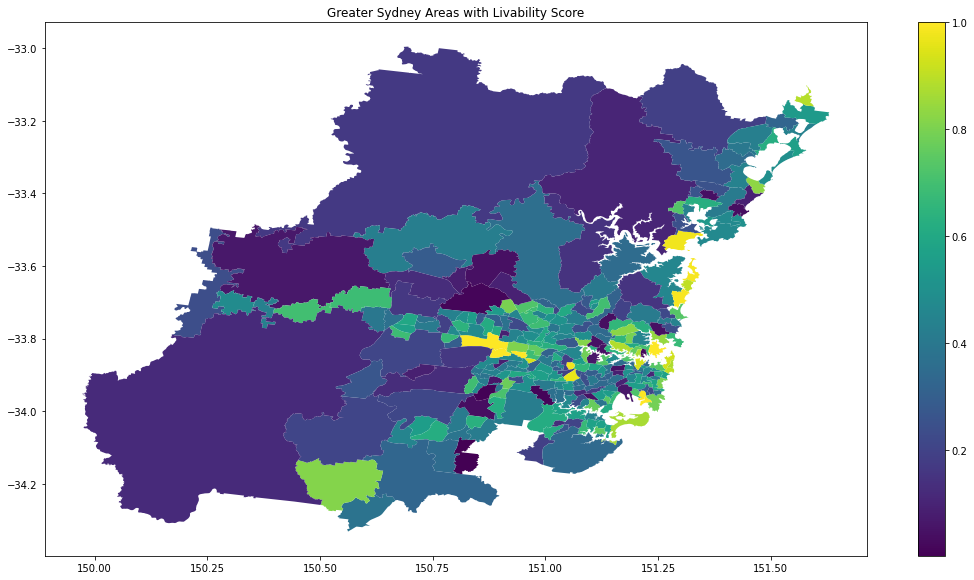

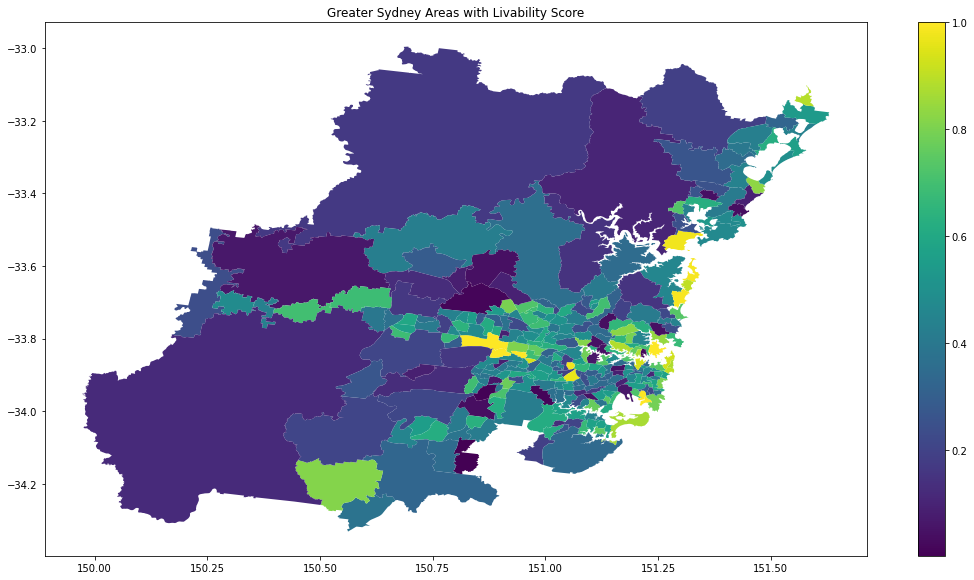

In [63]:
import matplotlib.pyplot as plt
greater_sydney_livability_scores_withNan = df_livability_scores.copy()

fig, ax1 = plt.subplots(1, 1, figsize=(15,8))
plt.tight_layout()
ax1.set_title("Greater Sydney Areas with Livability Score")
greater_sydney_livability_scores_withNan.plot(column='sigmoid', ax=ax1, legend=True)

if save_data:
    print("Saving fig")
    plt.savefig("greater_sydney_live_scores.png", bbox_inches='tight', facecolor=(1, 1, 1))

plt.show()




### Sigmoid Plots of City of Sydney

Saving fig


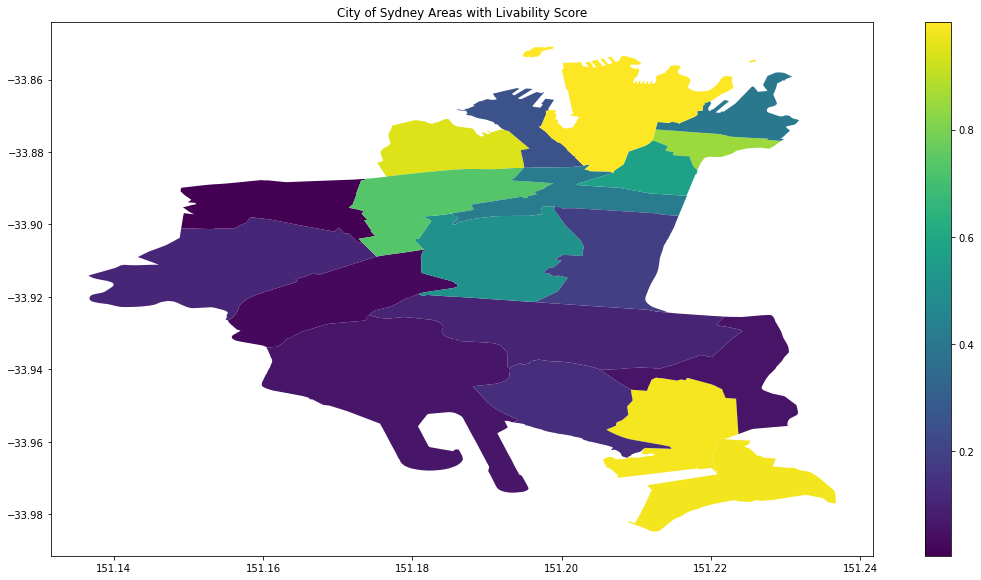

In [66]:
import matplotlib.pyplot as plt
sydney_livability_scores_withNan = df_livability_city_scores_withNan.copy()

fig, ax1 = plt.subplots(1, 1, figsize=(15,8))
plt.tight_layout()
ax1.set_title("City of Sydney Areas with Livability Score")
sydney_livability_scores_withNan.plot(column='sigmoid', ax=ax1, legend=True)

if save_data:
    print("Saving fig")
    plt.savefig("city_of_sydney_live_scores.png", bbox_inches='tight', facecolor=(1, 1, 1))

plt.show()


### Plot each z function

Saving fig


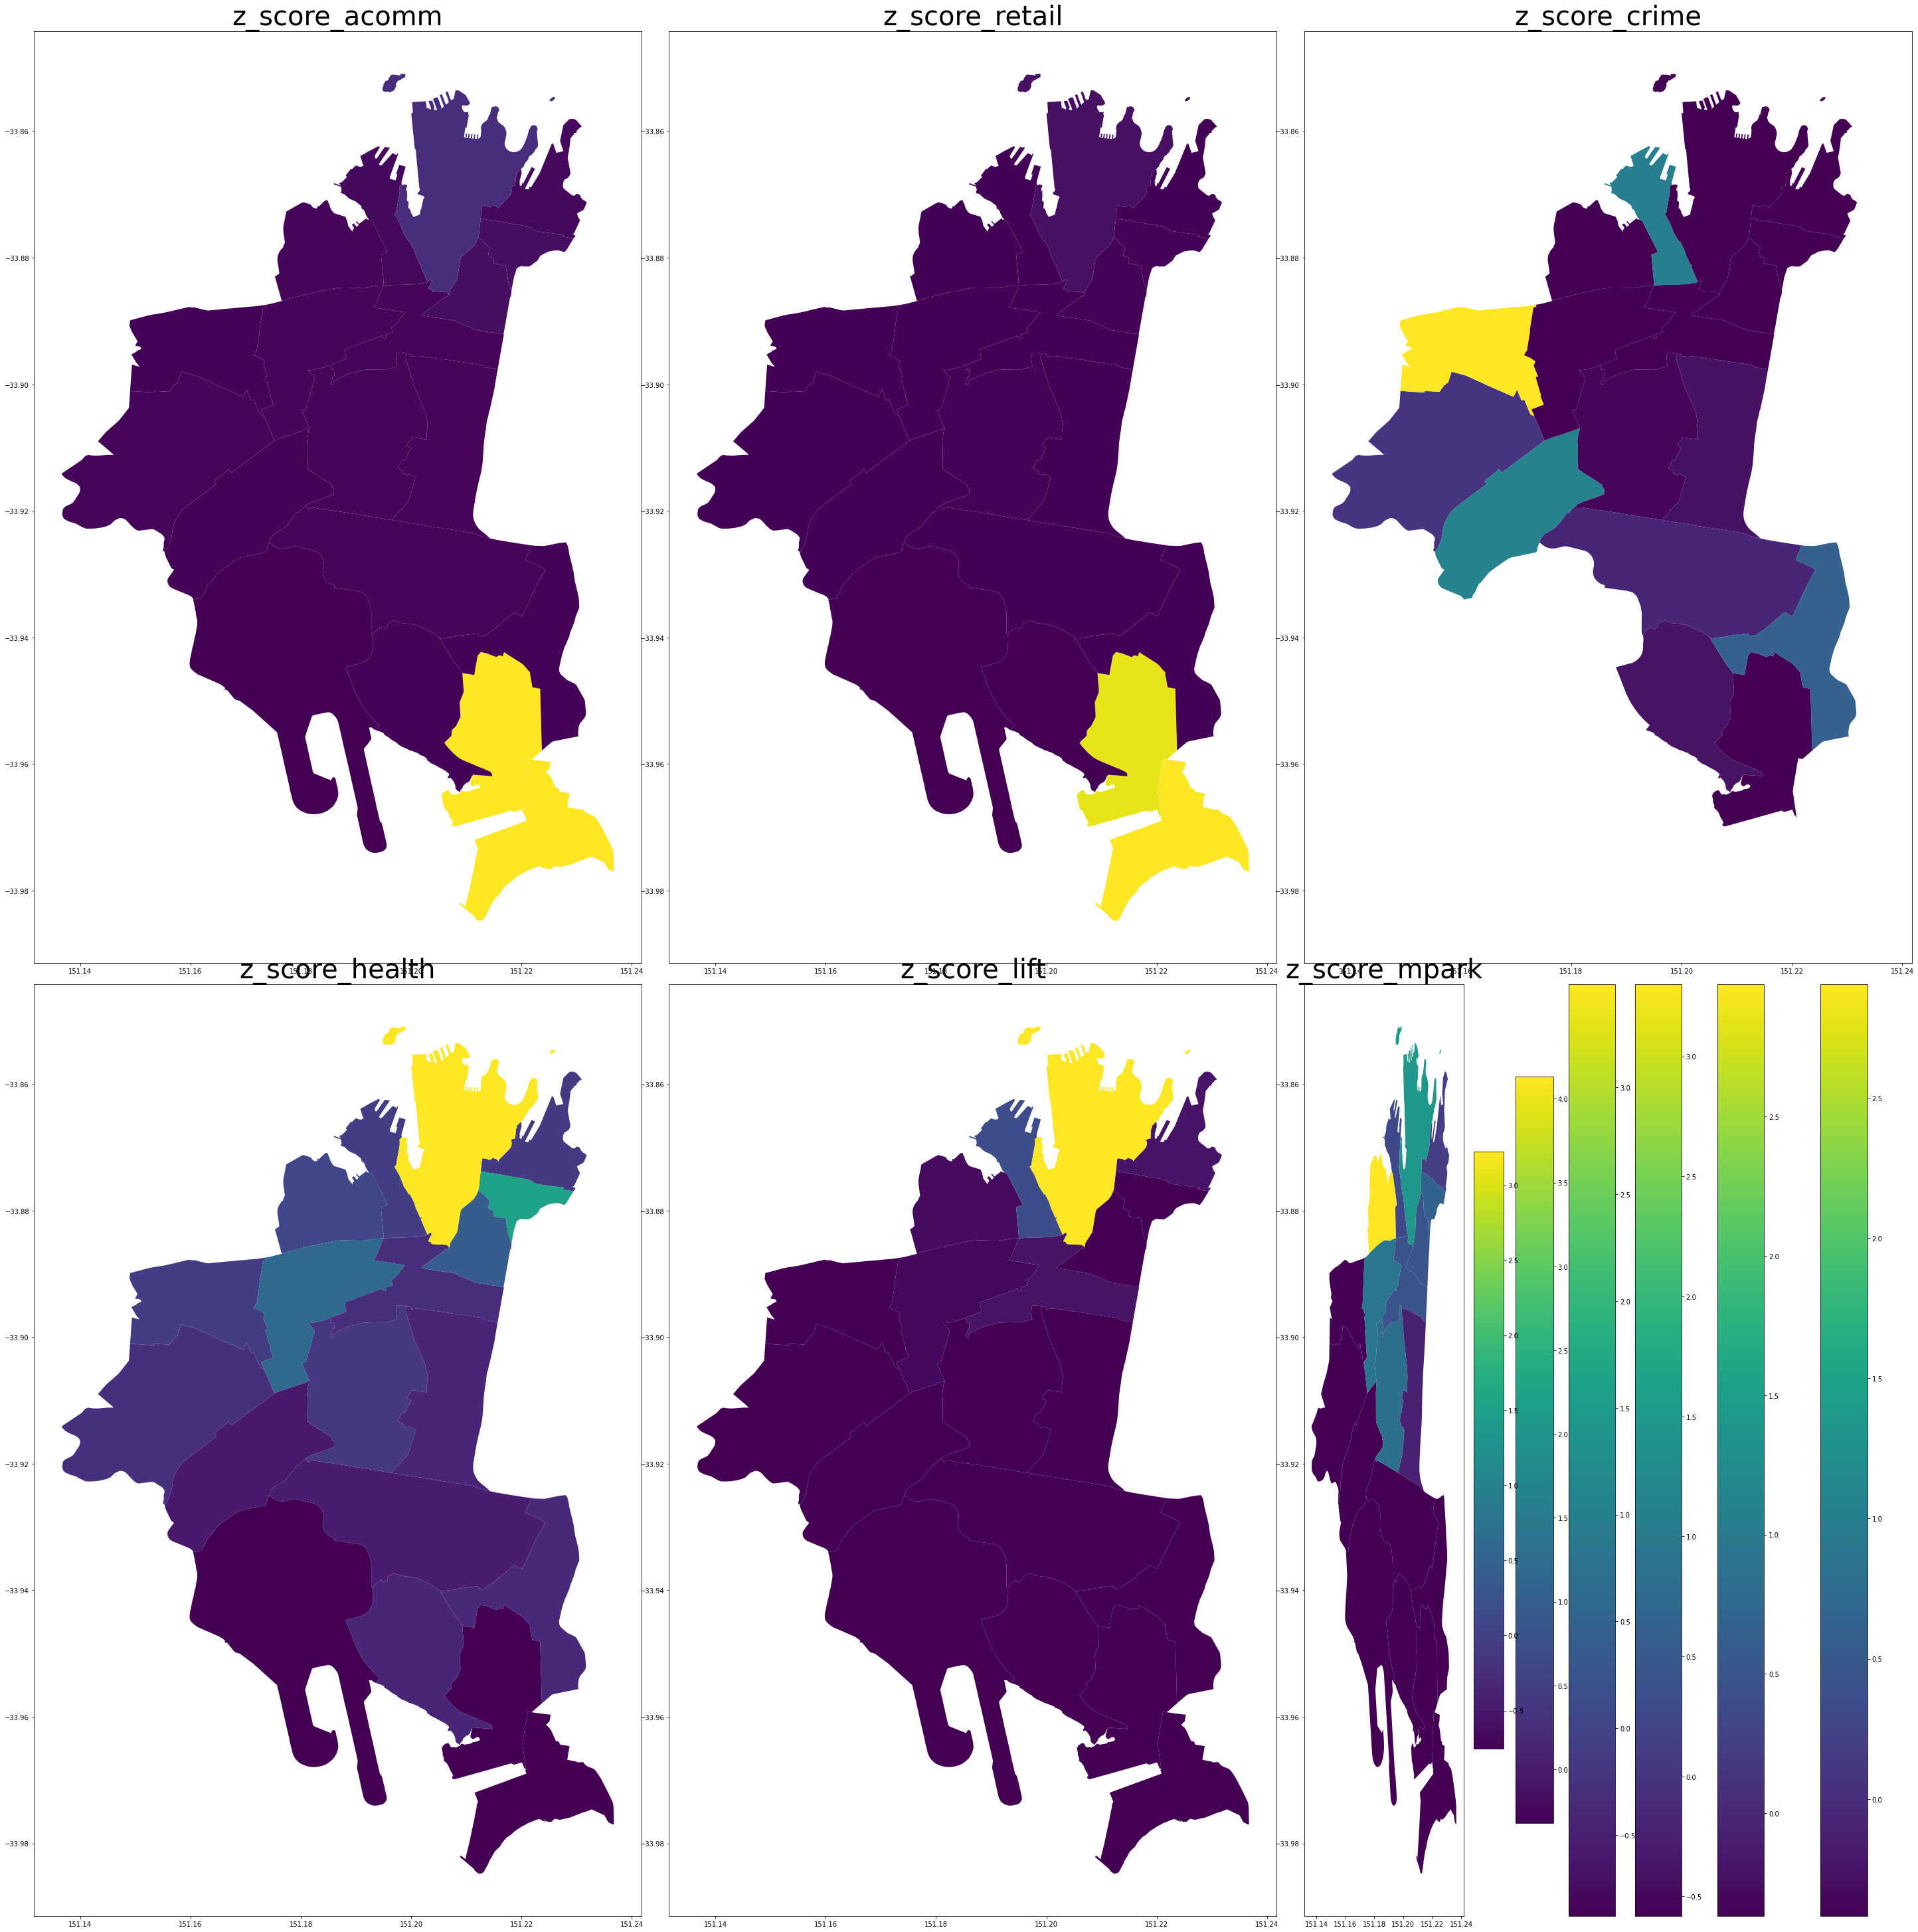

In [67]:
#viz scores for City of Sydney
df_livability_city_scores_withNan
score_headers = ['z_score_acomm','z_score_retail', 'z_score_crime' ,'z_score_health', 'z_score_lift', 'z_score_mpark']

fig, axis_2d = plt.subplots(2,3,  figsize=(40,40))
fig.tight_layout()

#we need to flatten the axis to zip
import itertools
axis = list(itertools.chain(*axis_2d))

plt.tight_layout()
assert(len(axis) == len(score_headers))
for col, ax in zip(score_headers, axis):
    ax.set_title(col, fontsize=40)
    df_livability_city_scores_withNan.plot(column=col, ax=ax, legend=True)

if save_data:
    print("Saving fig")
    plt.savefig("z_score_city.png", bbox_inches='tight', facecolor=(1, 1, 1))
    
plt.show()

### Correlation Related Plots

In [68]:

#plot monthly rent and annual household income against sigmoid
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,10))
fig.tight_layout()
gs_avg_monthy_rent = np.array(df_livability_sigmoid_noNan["avg_monthly_rent"])
gs_annual_income = np.array(df_livability_sigmoid_noNan["median_annual_household_income"])
gs_sigmoid = np.array(df_livability_sigmoid_noNan["sigmoid"])



ax1.set_title("Greater Sydney Avg. Rent and Income vs Sigmoid")
ax1.plot(gs_avg_monthy_rent, gs_sigmoid, 'go')
ax1.set_xlabel("Avg Rent ($)", fontsize=10)
ax1.set_ylabel("Sigmoid Score")

ax2.set_xlabel("Median Annual Income($)", fontsize=10)
ax2.set_ylabel("Sigmoid Score")
ax2.plot(gs_annual_income, gs_sigmoid, 'ro')
#(jesse:) note these scores align strongly with the correlation scores we calcualted as
# there is a stronger linear trend in the avg rent than in the median rent than in the annual
# income and the correlation score for the former > than the latter. 

if save_data:
    print("Saving fig")
    plt.savefig("rent_income_vs_sigmoid_greater_sydney.png", bbox_inches='tight', facecolor=(1, 1, 1))
    



Saving fig


In [69]:
conn.close()
db.dispose()